In [631]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

In [632]:
df = pd.read_csv('../data/stocks_quarterly.csv')

In [633]:
df.drop_duplicates(inplace=True)

In [634]:
cols_to_drop = df.isnull().mean().sort_values(ascending = False).head(45).index

In [635]:
cols_to_drop = list(cols_to_drop) + ['fiscalDateEnding','reportedDate','price','nasd_price','next_year_date','next_year_price','nasd_ny_price','Nasdaq_Performance', 'Stock_Performance']

In [636]:
df.drop(columns = cols_to_drop, inplace = True)

In [637]:
df = df.fillna(0)

In [638]:
columns = df.columns[0:-2]

In [644]:
column_transformer = make_column_transformer((MinMaxScaler(),columns),
                                              remainder="passthrough")

In [646]:
X = column_transformer .fit_transform(df)


In [629]:
df = pd.DataFrame(X,columns = df.columns)

In [630]:
df.isnull().sum()

grossProfit                              0
totalRevenue                             0
costOfRevenue                            0
costofGoodsAndServicesSold               0
operatingIncome                          0
sellingGeneralAndAdministrative          0
operatingExpenses                        0
interestExpense                          0
depreciationAndAmortization              0
incomeBeforeTax                          0
incomeTaxExpense                         0
netIncomeFromContinuingOperations        0
comprehensiveIncomeNetOfTax              0
ebit                                     0
ebitda                                   0
netIncome_x                              0
totalAssets                              0
totalCurrentAssets                       0
cashAndCashEquivalentsAtCarryingValue    0
cashAndShortTermInvestments              0
totalNonCurrentAssets                    0
propertyPlantEquipment                   0
otherCurrentAssets                       0
otherNonCur

In [531]:
y = np.array(df.groupby('symbol').head(1)['Label'])

In [532]:
tickers  = df['symbol'].unique()

In [533]:
new_data = []

for ticker in tickers:
    
    temp = df[df['symbol'] == ticker]
    temp.drop(columns = 'symbol', inplace = True)
    temp.drop(columns = 'Label', inplace = True)
    
    if len(temp)<17:
        add = pd.DataFrame(data=np.full((17 - len(temp),temp.shape[1]), -100_000),columns=temp.columns)
        temp = pd.concat([temp,add])
    
    new_data.append(np.array(temp))
        

/Users/patriciogarbino/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [534]:
X_new = np.array(new_data).astype('float32')

In [535]:
X_new.shape

(775, 17, 46)

In [536]:
y = y.astype('float32')

In [537]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.2)

In [571]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten,Dropout,Masking
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam


def init_model():

    model = Sequential()
    model.add(Masking(mask_value=-100_000, input_shape=(17,46)))
    model.add(LSTM(128, activation = 'tanh',return_sequences=True))
    model.add(LSTM(128, activation = 'tanh',return_sequences=True))
    model.add(LSTM(64, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss='BinaryCrossentropy', 
                  optimizer=Adam(learning_rate=0.00005), 
                  metrics=['accuracy',metrics.Precision()]) 
    
    
    return model
    

In [575]:
from tensorflow.keras.callbacks import EarlyStopping

model = init_model()
es = EarlyStopping(patience=1)

history = model.fit(X_train, y_train, 
                      batch_size=32, 
                      epochs=400, 
                      validation_split=0.2)

Epoch 1/400
16/16 [==============================] - 12s 220ms/step - loss: 0.6935 - accuracy: 0.4597 - precision_3: 0.4481 - val_loss: 0.6944 - val_accuracy: 0.4677 - val_precision_3: 0.4386
Epoch 2/400
16/16 [==============================] - 1s 43ms/step - loss: 0.6931 - accuracy: 0.5343 - precision_3: 0.4837 - val_loss: 0.6934 - val_accuracy: 0.5323 - val_precision_3: 0.4700
Epoch 3/400
16/16 [==============================] - 1s 43ms/step - loss: 0.6932 - accuracy: 0.5141 - precision_3: 0.4667 - val_loss: 0.6932 - val_accuracy: 0.5403 - val_precision_3: 0.4713
Epoch 4/400
16/16 [==============================] - 1s 44ms/step - loss: 0.6921 - accuracy: 0.5766 - precision_3: 0.5147 - val_loss: 0.6929 - val_accuracy: 0.5484 - val_precision_3: 0.4744
Epoch 5/400
16/16 [==============================] - 1s 44ms/step - loss: 0.6923 - accuracy: 0.5585 - precision_3: 0.4970 - val_loss: 0.6924 - val_accuracy: 0.5242 - val_precision_3: 0.4386
Epoch 6/400
16/16 [=============================

In [576]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 20ms/step - loss: 19.7324 - accuracy: 0.5613 - precision_3: 0.4524


[19.732398986816406, 0.5612903237342834, 0.4523809552192688]

In [577]:
def plot_history(history):
    fig = plt.figure(figsize = (10,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

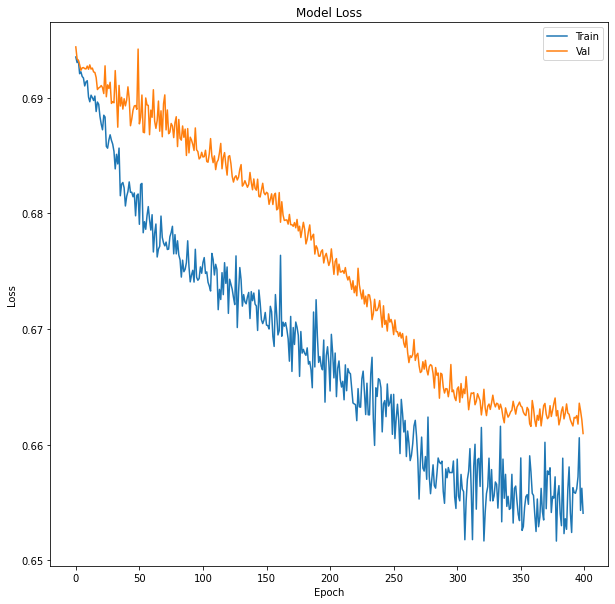

In [578]:
plot_history(history)